imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
import re
import nltk
from textblob import TextBlob
from textblob import Word
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
lemmatizer=nltk.WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Get the Data

In [3]:
twitter1=pd.read_csv('2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv',index_col=False)

shuffle the data

In [4]:
shuffled_index = np.random.permutation(twitter1.index)
twitter1 = twitter1.reindex(shuffled_index)

# print the shuffled DataFrame
print(twitter1)

       Unnamed: 0      id                                               text  \
3028         3062   13857  I do not differentiate a black man and a black...   
17319       17379   25420                                fucking disgusting!   
19842       19904  27038p  my colleague is a transgender bisexual woman, ...   
1294         1317   12068                                 That chair is vile   
38930       39029    8182               This lady is f**cking awesome in bed   
...           ...     ...                                                ...   
6401         6450   19845           Many of my closest colleagues are muslim   
30463       30531  33712p  it really shows how shallow greedy and PR-orie...   
29160       29227   32986  I'm completely mentally healthy. And I'm happy...   
6070         6119  19669p  There are many black people on my street which...   
15642       15698   24584  It is so annoying having to explain myself and...   

         label        type model_wrong 

#Prepaing the Data

In [5]:
print(twitter1.columns)

Index(['Unnamed: 0', 'id', 'text', 'label', 'type', 'model_wrong',
       'db.model_preds', 'status', 'round', 'split', 'annotator'],
      dtype='object')


In [6]:
print(twitter1.shape)
twitter1.nunique(axis=0)

(40623, 11)


Unnamed: 0        40623
id                40623
text              40463
label                 2
type                  7
model_wrong           2
db.model_preds    12118
status                2
round                 5
split                 3
annotator            20
dtype: int64

In [7]:
twitter1.dtypes

Unnamed: 0          int64
id                 object
text               object
label              object
type               object
model_wrong        object
db.model_preds    float64
status             object
round              object
split              object
annotator          object
dtype: object

get the difference in value to know if the set is balanced or not

In [8]:
twitter1['label'] = twitter1['label'].replace({'hate': 0, 'nothate': 1})

0    22124
1    18499
Name: label, dtype: int64


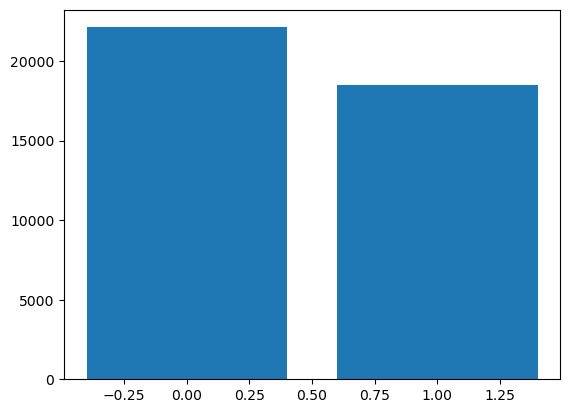

In [9]:
class_counts = twitter1['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

unbalanced; undersample
clean the data then make sure its balanced

I am going to divide this into 2 parts, a part were I clean and visualize the complete data (to be used later) and a part where I clean and viusalize the data I need only (label and text)

However, I will be using the text and label only, the other is just to show the difference between by analysis and the given analysis

##Only label and text

In [10]:
ctwitter1=twitter1.drop(['Unnamed: 0','id', 'type', 'model_wrong','db.model_preds', 'status','round','split','annotator'],axis=1)

In [11]:
ctwitter1.head()

,text,label
3028,I do not differentiate a black man and a black...,0
17319,fucking disgusting!,1
19842,"my colleague is a transgender bisexual woman, ...",0
1294,That chair is vile,1
38930,This lady is f**cking awesome in bed,1


In [12]:
ctwitter1.describe()

,label
count,40623.000000
mean,0.455382
std,0.498011
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


###Cleaning

Check for null values and drop if any

In [13]:
print(ctwitter1.isnull().sum())

text     0
label    0
dtype: int64


In [14]:
ctwitter1.dropna(inplace=True)

check for duplicates

In [15]:
duplicates = ctwitter1[ctwitter1.duplicated()]
if len(duplicates) > 0:
    print('Duplicate rows:')
    print(duplicates)
else:
    print('No duplicate rows found.')

Duplicate rows:
                                                    text  label
512                                       fuck off Boris      1
38897                  I endorse the genocide of Muslims      0
29366                     trans women are not real women      0
4609   Indians are doing great at disrupting our society      0
4293                              All Zionists are cheap      0
...                                                  ...    ...
1041   Pakistanis are just not as clean as British pe...      0
38546           Millenials were born in a comatose state      0
4973   Wish I hadnt bought this car, it couldnt be ...      1
2310   I wouldn't eat food that has been touched by a...      0
4237                                 Women are repulsive      0

[157 rows x 2 columns]


In [16]:
ctwitter1 = ctwitter1.drop_duplicates(keep='first')

In [17]:
print(ctwitter1.duplicated().sum())

0


replot to check balance

0    22025
1    18441
Name: label, dtype: int64


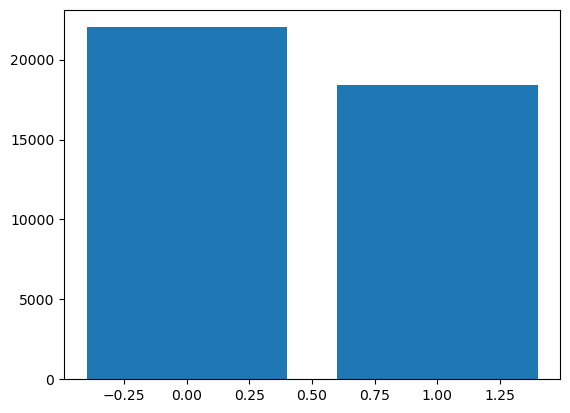

In [18]:
class_counts = ctwitter1['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

balance:
still unbalanced
undersampled
balance it

In [19]:
majority_class = ctwitter1[ctwitter1['label'] == 0]
minority_class = ctwitter1[ctwitter1['label'] == 1]
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)
balanced_df = pd.concat([undersampled_majority, minority_class])
balanced_df.to_csv('Balanced (2).csv', index=False)
ctwitter=pd.read_csv('Balanced (2).csv',index_col=False)

In [20]:
print(ctwitter.shape)
ctwitter.nunique(axis=0)

(36882, 2)


text     36879
label        2
dtype: int64

0    18441
1    18441
Name: label, dtype: int64


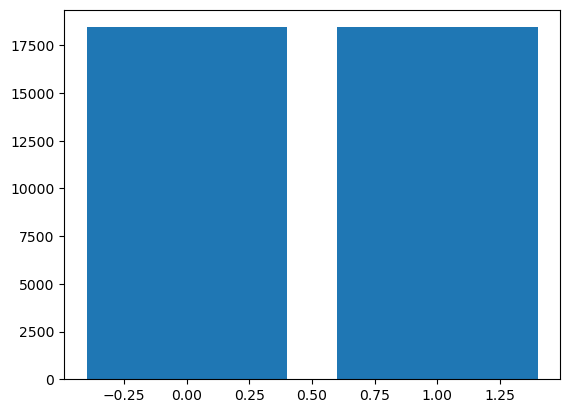

In [21]:
class_counts = ctwitter['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

0    18441
1    18441
Name: label, dtype: int64


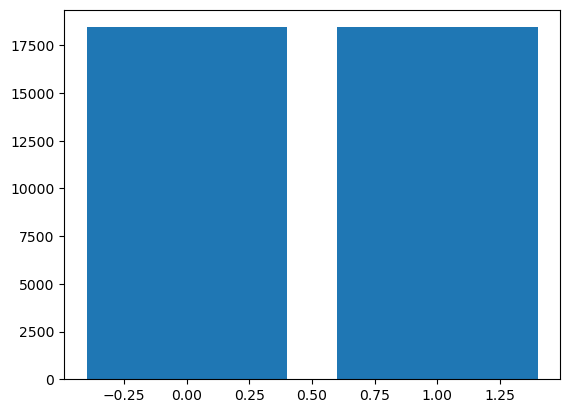

In [22]:
class_counts = ctwitter['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

###Visualing the data

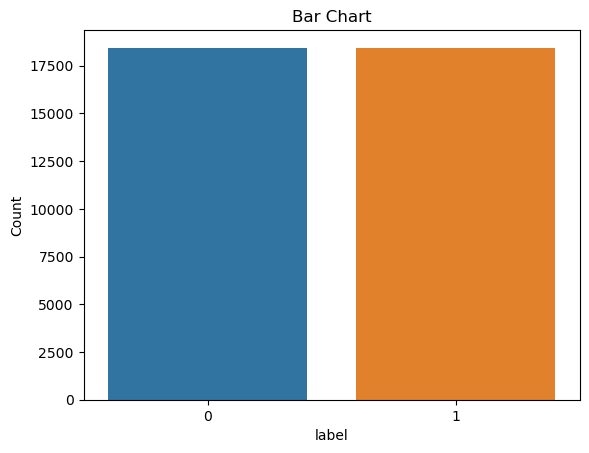

In [23]:
#bar chart
sns.countplot(x='label', data=ctwitter)
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Bar Chart')
plt.show()

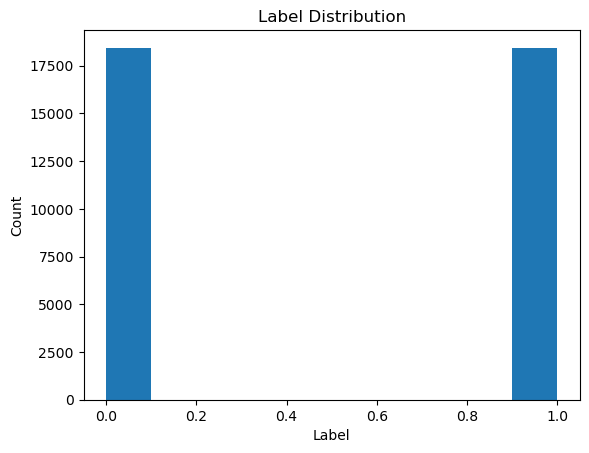

In [24]:
# Create a histogram of the label column
plt.hist(ctwitter['label'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [25]:
ctwitter.dropna(axis = 0,inplace = True)
for i in ctwitter.columns:
    print(i,":",ctwitter[str(i)].isnull().sum()/ctwitter.shape[0])

text : 0.0
label : 0.0


###Clean and Visualize using NLP

We first begin by converting all the characters to lower case to make it readable by our algorithms.

In [26]:
ctwitter["text"] = ctwitter["text"].apply(lambda i: " ".join(i.lower() for i in i.split()))
print(ctwitter['text'])

0                       i do not want to live near koshies
1        i love arabs. they are so hardworking. i love ...
2        oh women i hope you like hell for all these ab...
3                     why should indian people get rights?
4                             urgh, blacks are so tiresome
                               ...                        
36877    i'm looking for new best friends who love to g...
36878                                         cigars stink
36879                         so happy to have white teeth
36880             many of my closest colleagues are muslim
36881    it really shows how shallow greedy and pr-orie...
Name: text, Length: 36882, dtype: object


We use regex to match all numeraical values and remove them from the text. We all remove all that is not alphabetical and only use alphabetical characters

In [27]:
ctwitter["text"] = ctwitter["text"].str.replace(r"\d","")
ctwitter["text"] = ctwitter["text"].str.replace(r"[^\w\s]","")
ctwitter["text"] = ctwitter["text"].str.replace(r"[^[A-Za-z]\s]","")
print(ctwitter['text'])

0                       i do not want to live near koshies
1        i love arabs they are so hardworking i love th...
2        oh women i hope you like hell for all these ab...
3                      why should indian people get rights
4                              urgh blacks are so tiresome
                               ...                        
36877    im looking for new best friends who love to go...
36878                                         cigars stink
36879                         so happy to have white teeth
36880             many of my closest colleagues are muslim
36881    it really shows how shallow greedy and prorien...
Name: text, Length: 36882, dtype: object

C:\Users\user1\AppData\Local\Temp\ipykernel_23636\759435920.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  ctwitter["text"] = ctwitter["text"].str.replace(r"\d","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\759435920.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ctwitter["text"] = ctwitter["text"].str.replace(r"[^\w\s]","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\759435920.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ctwitter["text"] = ctwitter["text"].str.replace(r"[^[A-Za-z]\s]","")


remove all nonenglish words

In [28]:
import re
pattern = re.compile(r'\b[a-zA-Z]+\b')

In [29]:
def remove_non_english(text):
    return ' '.join(pattern.findall(text))

# apply the function to each text document
ctwitter['text'] = ctwitter['text'].apply(remove_non_english)

print(ctwitter)

                                                    text  label
0                     i do not want to live near koshies      0
1      i love arabs they are so hardworking i love th...      0
2      oh women i hope you like hell for all these ab...      0
3                    why should indian people get rights      0
4                            urgh blacks are so tiresome      0
...                                                  ...    ...
36877  im looking for new best friends who love to go...      1
36878                                       cigars stink      1
36879                       so happy to have white teeth      1
36880           many of my closest colleagues are muslim      1
36881  it really shows how shallow greedy and prorien...      1

[36882 rows x 2 columns]


We remove stopwords. Any words like "when, and, not, but, etc..." were removed

In [30]:
sw = stopwords.words("english")
ctwitter["text"] = ctwitter["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print(ctwitter['text'])

0                                   want live near koshies
1             love arabs hardworking love cleaning toilets
2                   oh women hope like hell aborted babies
3                                 indian people get rights
4                                     urgh blacks tiresome
                               ...                        
36877    im looking new best friends love go iceskating...
36878                                         cigars stink
36879                                    happy white teeth
36880                       many closest colleagues muslim
36881    really shows shallow greedy proriented psychol...
Name: text, Length: 36882, dtype: object


We lemmatize the words. This will revert all words back to their origin form. For example:

changing becomes change

Walks becomes Walk

Running becomes Run

In [31]:
from textblob import Word
ctwitter["text"] = ctwitter["text"].apply(lambda x: " ".join([Word(x).lemmatize()]))
print(ctwitter['text'])

0                                   want live near koshies
1             love arabs hardworking love cleaning toilets
2                   oh women hope like hell aborted babies
3                                 indian people get rights
4                                     urgh blacks tiresome
                               ...                        
36877    im looking new best friends love go iceskating...
36878                                         cigars stink
36879                                    happy white teeth
36880                       many closest colleagues muslim
36881    really shows shallow greedy proriented psychol...
Name: text, Length: 36882, dtype: object


Split up the words into tokens and store them in the data set.

In [32]:
ctwitter["tokens"] = ctwitter["text"].apply(lambda x: TextBlob(x).words)

Calculate the frequency of the word and store it in the data set.

In [33]:
ctwitter["frequency"] = ctwitter["text"].apply(lambda x: len(str(x).split(" ")))
ctwitter.groupby("frequency").max()

,text,label,tokens
frequency,,,
1,wrong,1,[wrong]
2,zombies subhummmman,1,"[zombies, subhummmman]"
3,zionists smell bad,1,"[zionists, smell, bad]"
4,zoo disgusting wanna die,1,"[zoo, disgusting, wan, na, die]"
5,zyklon b k k e,1,"[zyklon, b, k, k, e]"
...,...,...,...
187,oh god see city london television frightfully ...,0,"[oh, god, see, city, london, television, frigh..."
193,oh god see city london television frightfully ...,1,"[oh, god, see, city, london, television, frigh..."
198,adam even first white people earth lost tribes...,0,"[adam, even, first, white, people, earth, lost..."


In [34]:
blob_emptyline = []
for i in ctwitter["text"]:
    blob = TextBlob(i).sentiment
    blob_emptyline.append(blob)

We create a dataframe from the sentiment of the text.

In [35]:
blob=pd.DataFrame(blob_emptyline)

In [36]:
twitter_with_sentiment = pd.concat([ctwitter.reset_index(drop=True), blob], axis=1)

We add the sentiment column. This column will check the polarity of the text. If the polarity is above 0, then we have a positively perceived text, else it is a negatively perceived text!

In [37]:
twitter_with_sentiment["Sentiment"] =  np.where(twitter_with_sentiment["polarity"] >= 0 , "Positive", "Negative")

We plot the sentiment of the text as a histogram to better visualize it!

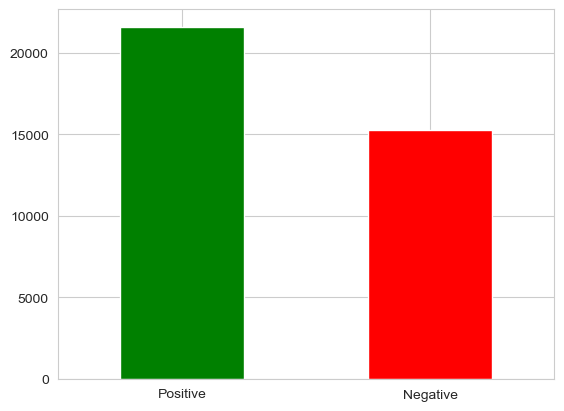

In [38]:
result = twitter_with_sentiment["Sentiment"].value_counts()
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
result.plot(kind="bar", rot=0, color=["green","red"]);

We offer a final view of the data as we finish the exploration. We see the maximum values of the sentiment and polarity of the text, count the number of positive and negative sentiments, and sort the data based on the polarity to better understand the impact of the polariy of the text on the mental state of an individual.

In [39]:
twitter_with_sentiment.groupby("Sentiment").count()

,text,label,tokens,frequency,polarity,subjectivity
Sentiment,,,,,,
Negative,15292,15292,15292,15292,15292,15292
Positive,21590,21590,21590,21590,21590,21590


In [40]:
twitter_with_sentiment.groupby("polarity").max()

,text,label,tokens,frequency,subjectivity,Sentiment
polarity,,,,,,
-1.000000,zoomers suck worst generation ever,1,"[zoomers, suck, worst, generation, ever]",23,1.000,Negative
-0.950000,hated vanilla sky boring movie,1,"[hated, vanilla, sky, boring, movie]",5,0.850,Negative
-0.900000,zionists repellent,1,"[zionists, repellent]",13,1.000,Negative
-0.900000,women evil follow trend matter stupid,1,"[women, evil, follow, trend, matter, stupid]",30,1.000,Negative
-0.875000,want encourage brutal murdering minorities bro...,1,"[want, encourage, brutal, murdering, minoritie...",9,1.000,Negative
...,...,...,...,...,...,...
0.833333,man style clothing rubbish especially gay,0,"[man, style, clothing, rubbish, especially, gay]",6,1.000,Positive
0.850000,women might definition beautiful,1,"[women, might, definition, beautiful]",16,1.000,Positive
0.875000,essence lgbtqs wonderful group successful peop...,1,"[essence, lgbtqs, wonderful, group, successful...",10,0.975,Positive


We combine the data sets and add the features into the new data set.

In [41]:
twitter_polarity = twitter_with_sentiment['polarity']
twitter_text = twitter_with_sentiment['text']
twitter_tokens = twitter_with_sentiment['tokens']
twitter_frequency = twitter_with_sentiment['frequency']
twitter_subjectivity = twitter_with_sentiment['subjectivity']
twitter_sentiment = twitter_with_sentiment['Sentiment']
twitter_label = twitter_with_sentiment['label']


d_data1={'Polarity':twitter_polarity,'Text':twitter_text,'Tokens':twitter_tokens,'Frequency':twitter_frequency,'Subjectivity':twitter_subjectivity,'Sentiment':twitter_sentiment,'Label':twitter_label}
tweet= pd.DataFrame(data=d_data1)
tweet

,Polarity,Text,Tokens,Frequency,Subjectivity,Sentiment,Label
0,0.118182,want live near koshies,"[want, live, near, koshies]",4,0.450000,Positive,0
1,0.500000,love arabs hardworking love cleaning toilets,"[love, arabs, hardworking, love, cleaning, toi...",6,0.600000,Positive,0
2,0.000000,oh women hope like hell aborted babies,"[oh, women, hope, like, hell, aborted, babies]",7,0.000000,Positive,0
3,0.000000,indian people get rights,"[indian, people, get, rights]",4,0.000000,Positive,0
4,-0.500000,urgh blacks tiresome,"[urgh, blacks, tiresome]",3,1.000000,Negative,0
...,...,...,...,...,...,...,...
36877,0.459091,im looking new best friends love go iceskating...,"[im, looking, new, best, friends, love, go, ic...",9,0.388636,Positive,1
36878,0.000000,cigars stink,"[cigars, stink]",2,0.000000,Positive,1
36879,0.400000,happy white teeth,"[happy, white, teeth]",3,0.500000,Positive,1
36880,0.500000,many closest colleagues muslim,"[many, closest, colleagues, muslim]",4,0.500000,Positive,1


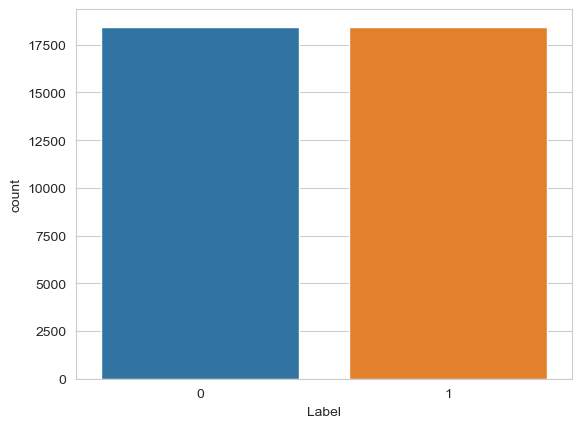

In [42]:
sns.countplot(data=tweet,x="Label")
plt.show()

Same observation can be seen when we replot the sentiment count.

<Axes: >

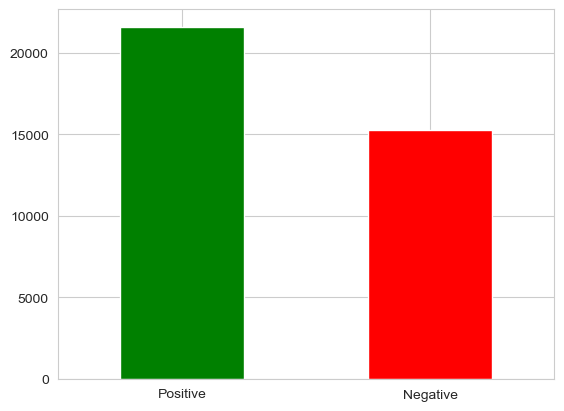

In [43]:
result = tweet["Sentiment"].value_counts()
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
result.plot(kind="bar", rot=0, color=["green","red"])

In [44]:
tweet.groupby("Sentiment").count()

,Polarity,Text,Tokens,Frequency,Subjectivity,Label
Sentiment,,,,,,
Negative,15292,15292,15292,15292,15292,15292
Positive,21590,21590,21590,21590,21590,21590


In [45]:
tweet.groupby("Polarity").max()

,Text,Tokens,Frequency,Subjectivity,Sentiment,Label
Polarity,,,,,,
-1.000000,zoomers suck worst generation ever,"[zoomers, suck, worst, generation, ever]",23,1.000,Negative,1
-0.950000,hated vanilla sky boring movie,"[hated, vanilla, sky, boring, movie]",5,0.850,Negative,1
-0.900000,zionists repellent,"[zionists, repellent]",13,1.000,Negative,1
-0.900000,women evil follow trend matter stupid,"[women, evil, follow, trend, matter, stupid]",30,1.000,Negative,1
-0.875000,want encourage brutal murdering minorities bro...,"[want, encourage, brutal, murdering, minoritie...",9,1.000,Negative,1
...,...,...,...,...,...,...
0.833333,man style clothing rubbish especially gay,"[man, style, clothing, rubbish, especially, gay]",6,1.000,Positive,0
0.850000,women might definition beautiful,"[women, might, definition, beautiful]",16,1.000,Positive,1
0.875000,essence lgbtqs wonderful group successful peop...,"[essence, lgbtqs, wonderful, group, successful...",10,0.975,Positive,1


In [46]:
#tweet.corr()

###More Visuializing

Extracted the hate speech entries from the data sets.

In [47]:
hate = ctwitter[ctwitter['label'] == 0]
hate

,text,label,tokens,frequency
0,want live near koshies,0,"[want, live, near, koshies]",4
1,love arabs hardworking love cleaning toilets,0,"[love, arabs, hardworking, love, cleaning, toi...",6
2,oh women hope like hell aborted babies,0,"[oh, women, hope, like, hell, aborted, babies]",7
3,indian people get rights,0,"[indian, people, get, rights]",4
4,urgh blacks tiresome,0,"[urgh, blacks, tiresome]",3
...,...,...,...,...
18436,party launching campaign entitled mosques futu...,0,"[party, launching, campaign, entitled, mosques...",23
18437,care perceive continue call n g g e r,0,"[care, perceive, continue, call, n, g, g, e, r]",9
18438,trashy dont wanna near dont really like chinks,0,"[trashy, dont, wan, na, near, dont, really, li...",8
18439,women good nothing,0,"[women, good, nothing]",3


In [48]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
text = " ".join(i for i in hate.text)

In [49]:
vocab = [ ]
label = []
for _,row in ctwitter.iterrows():
    a = row['text'].split()
    if(row['label'] == '0'):
        label+=[0 for i in range(len(a))]
    else:
        label+=[1 for i in range(len(a))]
    vocab+=a

In [50]:
vocab_model_relation = pd.DataFrame({'Words': vocab ,'Label': label })
vocab_model_relation.head()

,Words,Label
0,want,1
1,live,1
2,near,1
3,koshies,1
4,love,1


We counted the most prominent words in the word cloud.

In [51]:
words = vocab_model_relation['Words'].value_counts().index
words

Index(['people', 'fucking', 'black', 'like', 'women', 'dont', 'love', 'think',
       'would', 'im',
       ...
       'countrymen', 'niggish', 'eliiiimiiiinateeed', 'traaaniiieeesss',
       'nongoys', 'obtuse', 'foids', 'rakhine', 'edging', 'cigars'],
      dtype='object', length=20545)

In [52]:
word_counts = {word: 0 for word in words}

for string in ctwitter['text']:
    for word in string.split():
        if word in word_counts:
            word_counts[word] += 1

# Sort the dictionary by count in descending order
word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

count = 0
for word, count_val in word_counts.items():
    print(f'{word}: {count_val}')
    count += 1
    if count == 10:
        break

people: 7275
fucking: 3612
black: 3529
like: 3411
women: 3376
dont: 3313
love: 2488
think: 2426
would: 1900
im: 1758


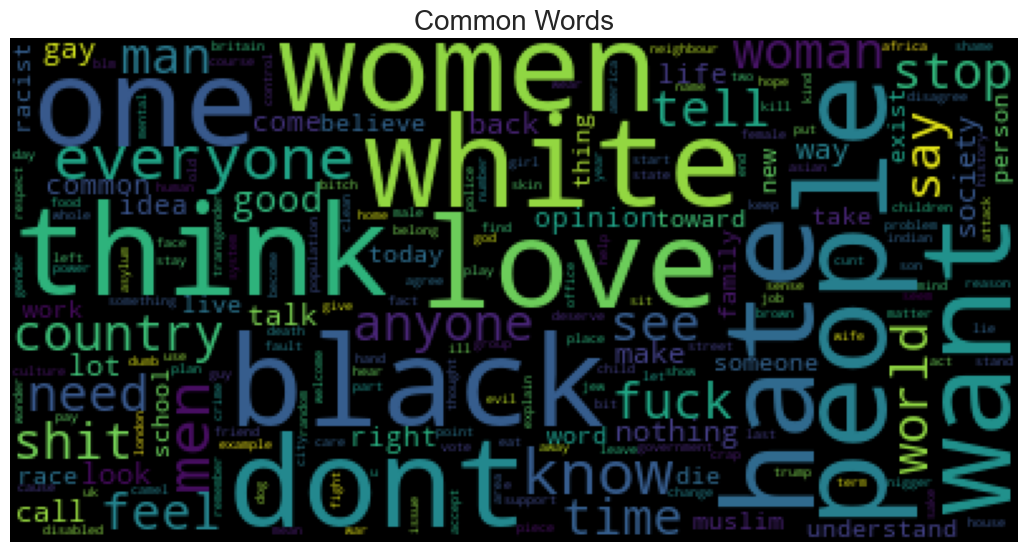

In [53]:
from wordcloud import WordCloud
def wc(data,bgcolor,title):
    plt.figure(figsize = (13,10))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.title(title , fontsize = 20)
    plt.imshow(wc)
    plt.axis('off')

wc(words,'black','Common Words')

##All data

###Cleaning

Check for null values

In [54]:
print(twitter1.isnull().sum())

Unnamed: 0            0
id                    0
text                  0
label                 0
type                  0
model_wrong       14526
db.model_preds    14526
status                0
round                 0
split                 0
annotator             0
dtype: int64


In [55]:
twitter1.dropna(inplace=True)

check for duplicates

In [56]:
duplicates = twitter1[twitter1.duplicated()]
if len(duplicates) > 0:
    print('Duplicate rows:')
    print(duplicates)
else:
    print('No duplicate rows found.')

No duplicate rows found.


In [57]:
twitter1 = twitter1.drop_duplicates(keep='first')

In [58]:
print(twitter1.duplicated().sum())

0


replot to check balance

0    15253
1    10844
Name: label, dtype: int64


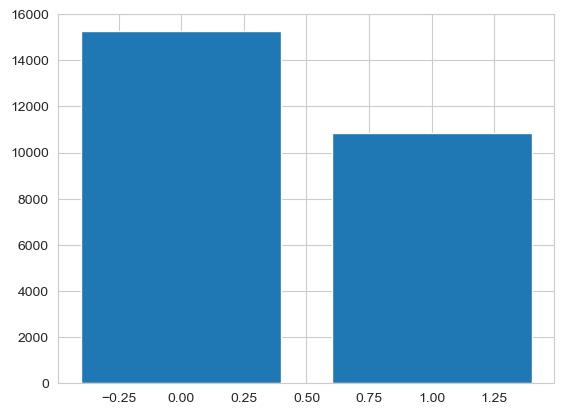

In [59]:
class_counts = twitter1['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

balance:
still unbalanced
undersampled
balance it

In [60]:
majority_class = twitter1[twitter1['label'] == 0]
minority_class = twitter1[twitter1['label'] == 1]
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)
balanced_df = pd.concat([undersampled_majority, minority_class])
balanced_df.to_csv('Balanced (1).csv', index=False)
twitter=pd.read_csv('Balanced (1).csv',index_col=False)

In [61]:
print(twitter.shape)
twitter.nunique(axis=0)

(21688, 11)


Unnamed: 0        21688
id                21688
text              21602
label                 2
type                  7
model_wrong           2
db.model_preds    10477
status                1
round                 3
split                 3
annotator            11
dtype: int64

In [62]:
#twitter.corr()

0    10844
1    10844
Name: label, dtype: int64


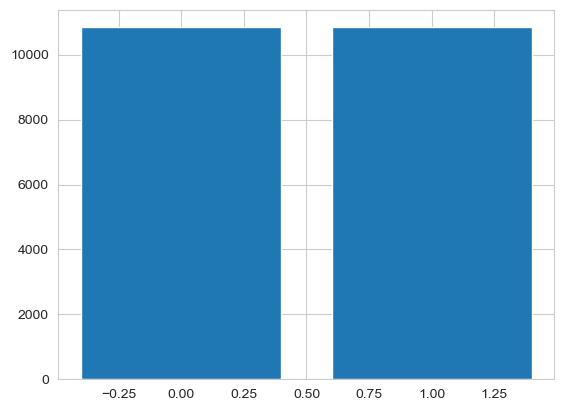

In [63]:
class_counts = twitter['label'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

###Visualizing the data

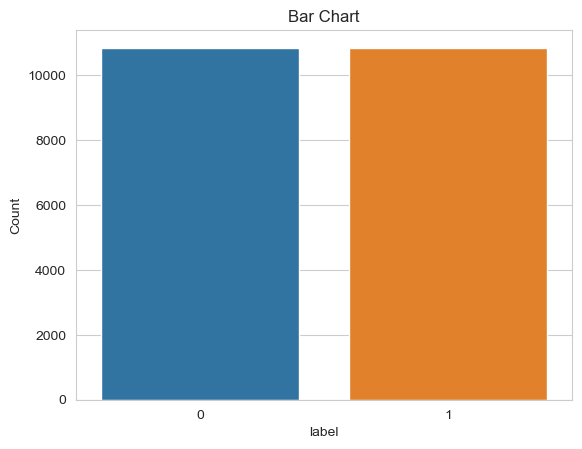

In [64]:
#bar chart
sns.countplot(x='label', data=twitter)
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Bar Chart')
plt.show()

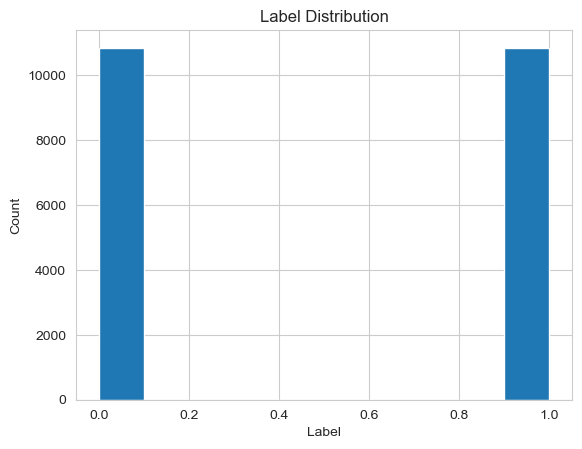

In [65]:
# Create a histogram of the label column
plt.hist(twitter['label'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [66]:
twitter.groupby('type').count()['id']

type
animosity           825
dehumanization      267
derogation         3827
none              10844
notgiven           5398
support              49
threatening         478
Name: id, dtype: int64

In [67]:
twitter['type'].nunique()

7

In [68]:
twitter.dropna(axis = 0,inplace = True)
for i in twitter.columns:
    print(i,":",twitter[str(i)].isnull().sum()/twitter.shape[0])

Unnamed: 0 : 0.0
id : 0.0
text : 0.0
label : 0.0
type : 0.0
model_wrong : 0.0
db.model_preds : 0.0
status : 0.0
round : 0.0
split : 0.0
annotator : 0.0


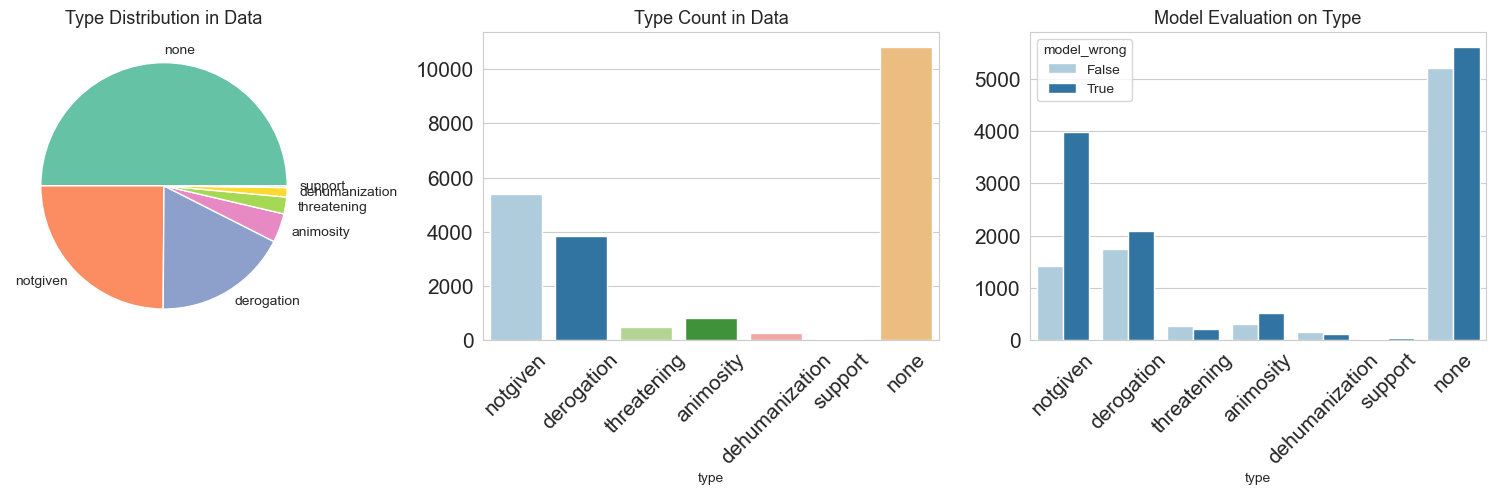

In [69]:
fig,ax = plt.subplots(ncols = 3, figsize = (20,4) , dpi = 100)

colors = ['#66c2a5', '#fc8d62' , '#8da0cb' ,'#e78ac3' , '#a6d854' , '#ffd92f','#e5c494']
twitter['type'].value_counts().plot(kind = 'pie',ax = ax[0], labels = twitter['type'].value_counts().index , colors = colors)
sns.countplot(x = 'type',data = twitter , ax = ax[1] , palette = 'Paired')
sns.countplot(x = 'type' , data = twitter , hue = 'model_wrong', palette = 'Paired')

for i in range(3):
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='x', labelsize=15 , rotation = 45)
    ax[i].tick_params(axis='y', labelsize=15)

ax[0].set_title('Type Distribution in Data', fontsize=13)
ax[1].set_title('Type Count in Data', fontsize=13)
ax[2].set_title('Model Evaluation on Type', fontsize = 13)

plt.show()

graph showing what the model used here got wrong and right

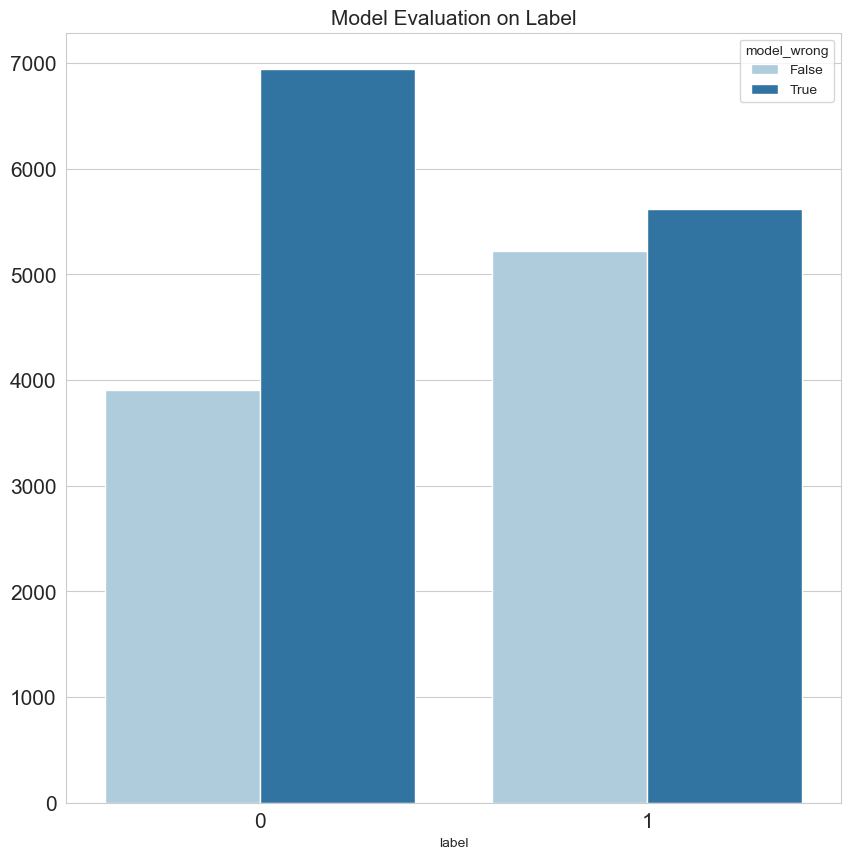

In [70]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'label' , data = twitter, hue = 'model_wrong' , palette = 'Paired')
plt.ylabel("")
plt.tick_params(axis = 'x',labelsize = 15)
plt.tick_params(axis = 'y',labelsize = 15)
plt.title("Model Evaluation on Label" , fontsize = 15)
plt.show()

get the count

In [71]:
class_counts2 = twitter['model_wrong'].value_counts()
right_count1=class_counts2[0];
wrong_count1=class_counts2[1];
print(class_counts2)

True     12565
False     9123
Name: model_wrong, dtype: int64


###Clean and Visualize using NLP

We first begin by converting all the characters to lower case to make it readable by our algorithms.

In [72]:
twitter["text"] = twitter["text"].apply(lambda i: " ".join(i.lower() for i in i.split()))
print(twitter['text'])

0                             chinks are worse than snakes
1        african-descended people are infamous for bein...
2        i would obtain great satisfaction from seeing ...
3        this is getting out of hand now, i have had 5 ...
4        as a guy i've dated dwarves, but i wouldn't da...
                               ...                        
21683    i do not understand why so many have a problem...
21684                this zoo is so disgusting i wanna die
21685                         black women are not panthers
21686                                my tv is fucking poor
21687             many of my closest colleagues are muslim
Name: text, Length: 21688, dtype: object


We use regex to match all numeraical values and remove them from the text. We all remove all that is not alphabetical and only use alphabetical characters

In [73]:
twitter["text"] = twitter["text"].str.replace(r"\d","")
twitter["text"] = twitter["text"].str.replace(r"[^\w\s]","")
twitter["text"] = twitter["text"].str.replace(r"[^[A-Za-z]\s]","")
print(twitter['text'])

0                             chinks are worse than snakes
1        africandescended people are infamous for being...
2        i would obtain great satisfaction from seeing ...
3        this is getting out of hand now i have had  ar...
4        as a guy ive dated dwarves but i wouldnt date ...
                               ...                        
21683    i do not understand why so many have a problem...
21684                this zoo is so disgusting i wanna die
21685                         black women are not panthers
21686                                my tv is fucking poor
21687             many of my closest colleagues are muslim
Name: text, Length: 21688, dtype: object


C:\Users\user1\AppData\Local\Temp\ipykernel_23636\621340184.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter["text"] = twitter["text"].str.replace(r"\d","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\621340184.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter["text"] = twitter["text"].str.replace(r"[^\w\s]","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\621340184.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter["text"] = twitter["text"].str.replace(r"[^[A-Za-z]\s]","")


remove all nonenglish words

In [74]:
import re
pattern = re.compile(r'\b[a-zA-Z]+\b')

In [75]:
def remove_non_english(text):
    return ' '.join(pattern.findall(text))

# apply the function to each text document
twitter['text'] = twitter['text'].apply(remove_non_english)

print(twitter)

       Unnamed: 0     id                                               text  \
0            4448  15980                       chinks are worse than snakes   
1           27968  32299  africandescended people are infamous for being...   
2            8740  21048  i would obtain great satisfaction from seeing ...   
3           18943  26534  this is getting out of hand now i have had arg...   
4           31194  34242  as a guy ive dated dwarves but i wouldnt date ...   
...           ...    ...                                                ...   
21683       20009  27101  i do not understand why so many have a problem...   
21684       40285   9530              this zoo is so disgusting i wanna die   
21685        8029  20678                       black women are not panthers   
21686        5698  17263                              my tv is fucking poor   
21687        6450  19845           many of my closest colleagues are muslim   

       label         type  model_wrong  db.model_pr

We remove stopwords. Any words like "when, and, not, but, etc..." were removed

In [76]:
sw = stopwords.words("english")
twitter["text"] = twitter["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print(twitter['text'])

0                                      chinks worse snakes
1        africandescended people infamous least accompl...
2        would obtain great satisfaction seeing refugee...
3        getting hand arguments today already merely ex...
4        guy ive dated dwarves wouldnt date midget dwar...
                               ...                        
21683                 understand many problem trans people
21684                             zoo disgusting wanna die
21685                                 black women panthers
21686                                      tv fucking poor
21687                       many closest colleagues muslim
Name: text, Length: 21688, dtype: object


We lemmatize the words. This will revert all words back to their origin form. For example:

changing becomes change

Walks becomes Walk

Running becomes Run

In [77]:
from textblob import Word
twitter["text"] = twitter["text"].apply(lambda x: " ".join([Word(x).lemmatize()]))
print(twitter['text'])

0                                      chinks worse snakes
1        africandescended people infamous least accompl...
2        would obtain great satisfaction seeing refugee...
3        getting hand arguments today already merely ex...
4        guy ive dated dwarves wouldnt date midget dwar...
                               ...                        
21683                 understand many problem trans people
21684                             zoo disgusting wanna die
21685                                 black women panthers
21686                                      tv fucking poor
21687                       many closest colleagues muslim
Name: text, Length: 21688, dtype: object


Extracted the hate speech entries from the data sets.

In [78]:
hate = twitter[twitter['label'] == 0]
hate

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,4448,15980,chinks worse snakes,0,notgiven,False,0.07264,dynabench entry,1,dev,trrf46jwfp
1,27968,32299,africandescended people infamous least accompl...,0,derogation,True,0.97425,dynabench entry,3a,train,gnzuctwed3
2,8740,21048,would obtain great satisfaction seeing refugee...,0,threatening,False,0.00032,dynabench entry,2a,train,e3dsmnspob
3,18943,26534,getting hand arguments today already merely ex...,0,derogation,True,0.98135,dynabench entry,2a,train,elgzdd8tvb
4,31194,34242,guy ive dated dwarves wouldnt date midget dwar...,0,derogation,False,0.00001,dynabench entry,3a,train,gnzuctwed3
...,...,...,...,...,...,...,...,...,...,...,...
10839,18218,2592,blacks ruin neighbourhood,0,notgiven,False,0.09111,dynabench entry,1,train,tbubpfn6ip
10840,37124,5967,white people bigger brains makes sense charge,0,notgiven,True,0.98657,dynabench entry,1,train,gnzuctwed3
10841,34929,4438,asians unimportant,0,notgiven,True,0.98654,dynabench entry,1,train,elgzdd8tvb
10842,34659,43960,french minister correctly identifies french wa...,0,animosity,False,0.00001,dynabench entry,3a,train,lqlkttromx


In [79]:
twitter['model_wrong'] = twitter['model_wrong'].astype("string")
twitter['model_wrong'].dtype

string[python]

Extracted all the text of the hate speech observations. We use them to construct a word cloud.

In [80]:
vocab = [ ]
model_wrong = []
label = []
for _,row in twitter.iterrows():
    a = row['text'].split()
    if(row['label'] == '0'):
        label+=[0 for i in range(len(a))]
    else:
        label+=[1 for i in range(len(a))]
    if(row['model_wrong'] == 'True'):
        model_wrong+=[0 for i in range(len(a))]
    else:
        model_wrong+=[1 for i in range(len(a))]
    vocab+=a

In [81]:
vocab_model_relation = pd.DataFrame({'Words': vocab , 'Model Wrong': model_wrong ,'Label': label })
vocab_model_relation.head()

,Words,Model Wrong,Label
0,chinks,1,1
1,worse,1,1
2,snakes,1,1
3,africandescended,0,1
4,people,0,1


In [82]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
text = " ".join(i for i in hate.text)

We counted the most prominent words in the word cloud.

In [83]:
words = vocab_model_relation[vocab_model_relation['Model Wrong'] == 1]['Words'].value_counts().index
words

Index(['people', 'black', 'fucking', 'women', 'like', 'dont', 'love', 'would',
       'think', 'hate',
       ...
       'underlining', 'werner', 'braun', 'escaped', 'nasa', 'peoplehere',
       'perks', 'extremism', 'favorites', 'luxury'],
      dtype='object', length=12885)

In [84]:
words2 = vocab_model_relation[vocab_model_relation['Model Wrong'] == 0]['Words'].value_counts().index
words2

Index(['people', 'fucking', 'black', 'women', 'dont', 'like', 'think', 'hate',
       'white', 'love',
       ...
       'saved', 'bw', 'bookstore', 'nostrings', 'spits', 'carriers',
       'worshiping', 'trumptards', 'misanthropes', 'cockheads'],
      dtype='object', length=10328)

In [85]:
common_words = list(set(words)&set(words2))
common_words[:10]

['thin',
 'pumping',
 'insects',
 'images',
 'smuggling',
 'leaking',
 'prince',
 'interests',
 'transphobic',
 'collection']

In [86]:
word_counts = {word: 0 for word in common_words}

for string in twitter['text']:
    for word in string.split():
        if word in word_counts:
            word_counts[word] += 1

# Sort the dictionary by count in descending order
word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

count = 0
for word, count_val in word_counts.items():
    print(f'{word}: {count_val}')
    count += 1
    if count == 10:
        break

people: 3707
fucking: 2177
black: 2167
women: 1898
dont: 1707
like: 1644
love: 1129
think: 1124
hate: 1109
white: 1071


In [87]:
words = list(set(words).difference(set(common_words)))
words[:10]

['bloodline',
 'troubling',
 'schizophrenia',
 'authentically',
 'presses',
 'separated',
 'cardboard',
 'ghanaians',
 'scummy',
 'elevating']

In [88]:
words2 = list(set(words2).difference(set(common_words)))
words2[:10]

['obeys',
 'scholar',
 'raperefugee',
 'ambidextrous',
 'brioches',
 'incstuous',
 'pesky',
 'hoodwinking',
 'mudslime',
 'aerosol']

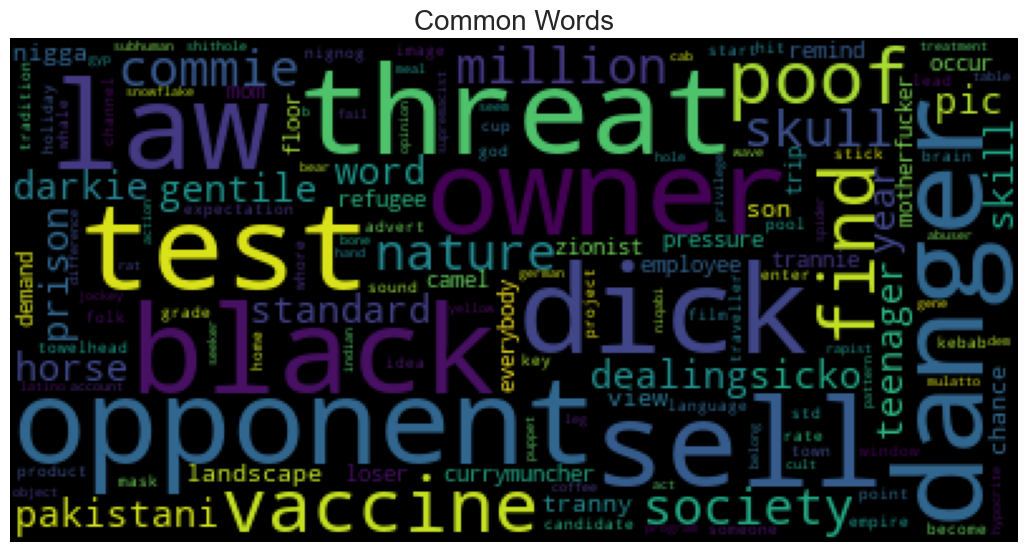

In [89]:
from wordcloud import WordCloud
def wc(data,bgcolor,title):
    plt.figure(figsize = (13,10))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.title(title , fontsize = 20)
    plt.imshow(wc)
    plt.axis('off')

wc(common_words,'black','Common Words')

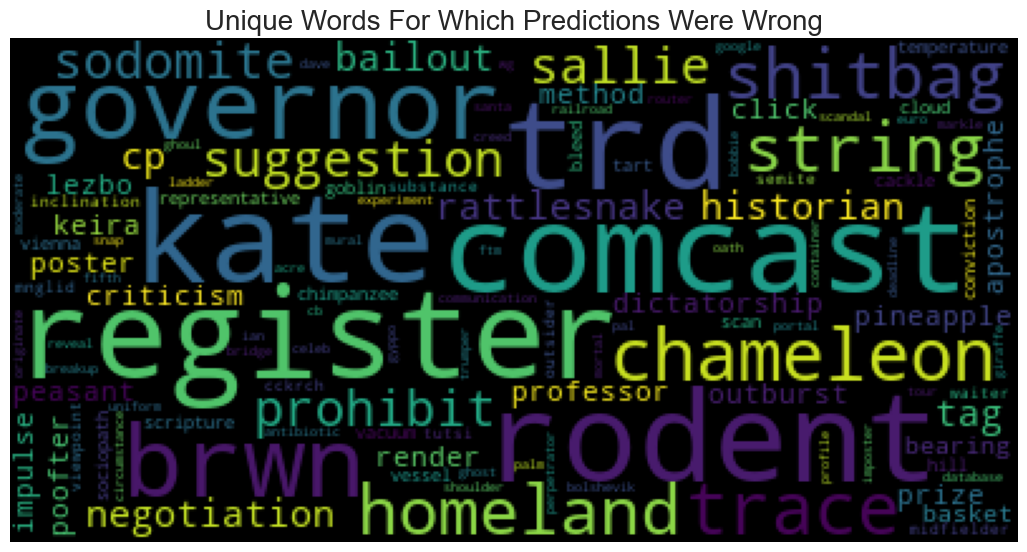

In [90]:
wc(words,'black','Unique Words For Which Predictions Were Wrong')

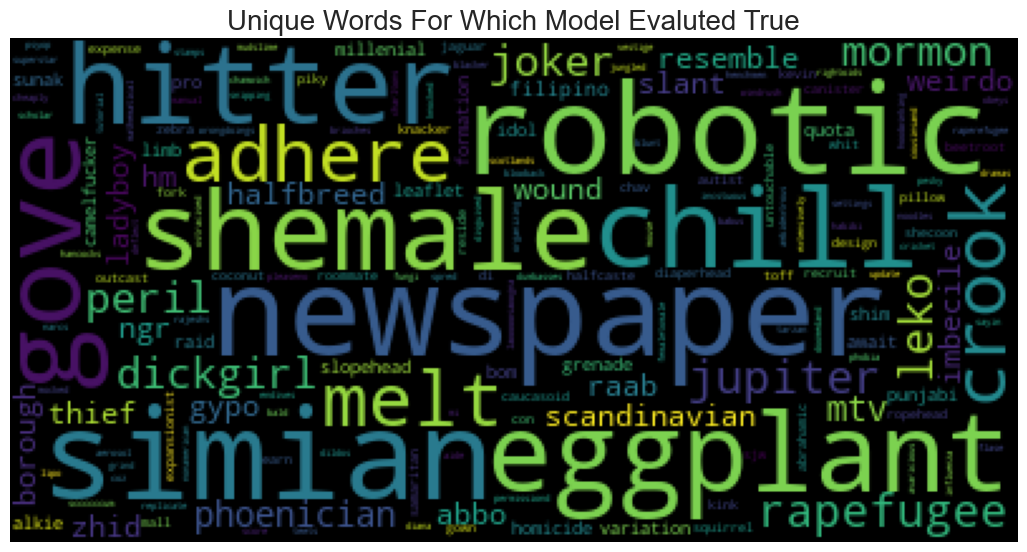

In [91]:
wc(words2,'black','Unique Words For Which Model Evaluted True')

Text(0.5, 1.0, 'Model Got Them Wrong')

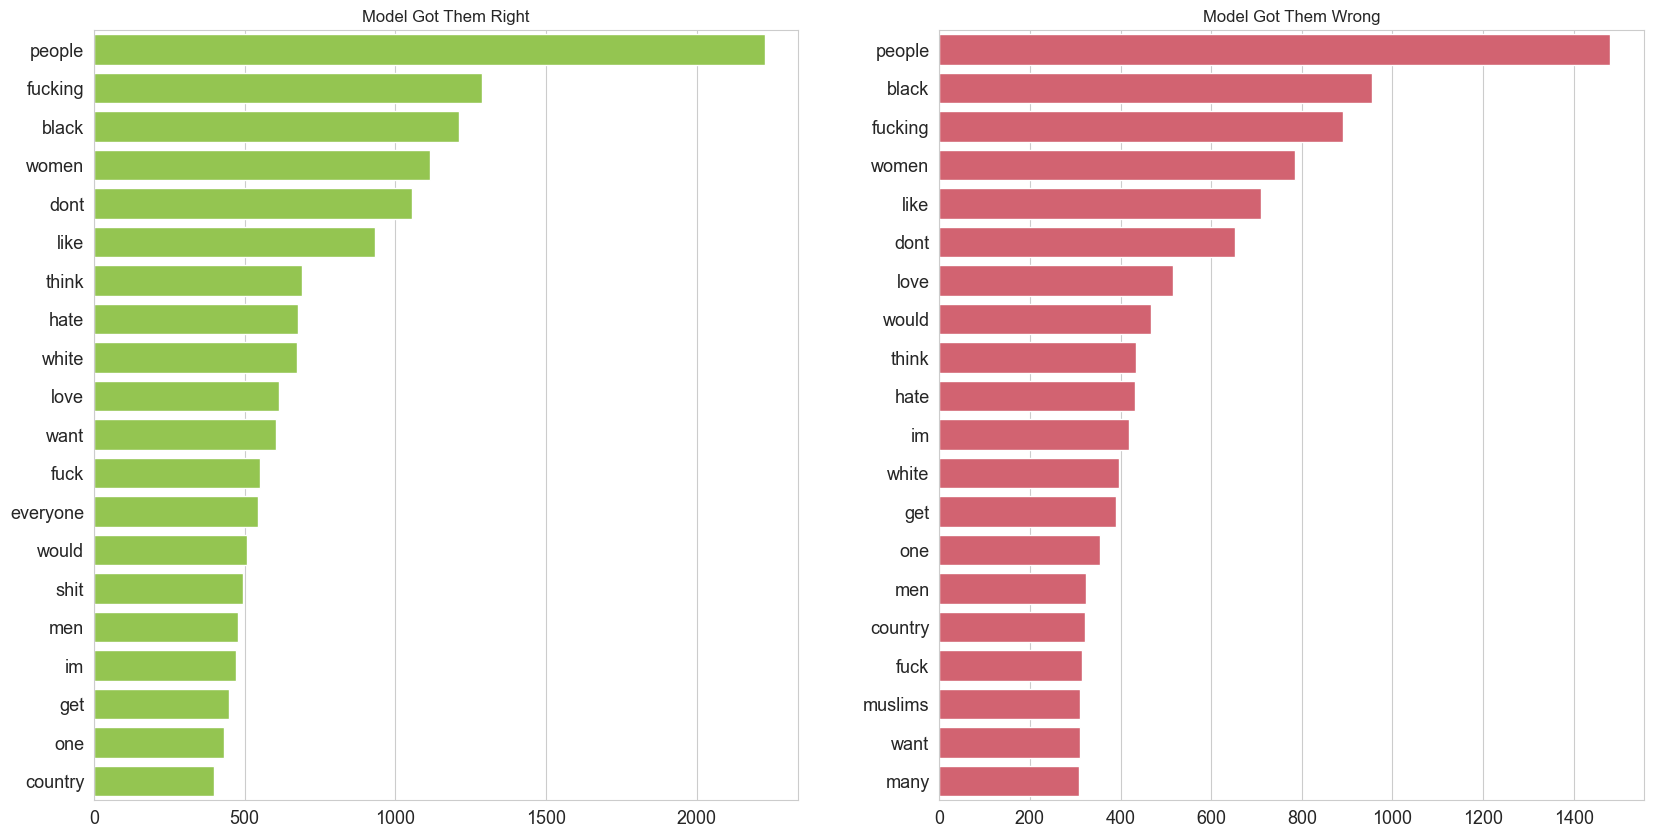

In [92]:
fig , ax = plt.subplots(ncols = 2,figsize = (20,10) , dpi = 100)

sns.barplot(y = vocab_model_relation[vocab_model_relation['Model Wrong'] == 0]['Words'].value_counts().index[0:20] , x = vocab_model_relation[vocab_model_relation['Model Wrong'] == 0]['Words'].value_counts().values[:20], ax = ax[0] , color = '#97d83e')
sns.barplot(y = vocab_model_relation[vocab_model_relation['Model Wrong'] == 1]['Words'].value_counts().index[0:20] , x = vocab_model_relation[vocab_model_relation['Model Wrong'] == 1]['Words'].value_counts().values[:20], ax = ax[1] , color = '#e55063')

for i in range(2):
    ax[i].tick_params(axis = 'x' , labelsize = 13)
    ax[i].tick_params(axis = 'y' , labelsize = 13)

ax[0].set_title('Model Got Them Right')
ax[1].set_title('Model Got Them Wrong')

In [93]:
class_counts2 = twitter['model_wrong'].value_counts()
right_count5=class_counts2[0];
wrong_count5=class_counts2[1];
print(class_counts2)

True     12565
False     9123
Name: model_wrong, dtype: Int64


##Splitting the data

Another way to extract features from the words is using a word count vector. The word count vector will contain all the words and store their count.

In [94]:
text_list=[]
for text in tweet.Text:
    description=re.sub("[^a-zA-Z]"," ",text)
    description=description.lower()
    description=nltk.word_tokenize(text)
    description=[lemmatizer.lemmatize(word) for word in text]
    description="".join(description)
    text_list.append(description)

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer=CountVectorizer(max_features=25000,stop_words="english")
count_vector=count_vectorizer.fit_transform(text_list).toarray()

In [96]:
x=count_vector
y=tweet["Label"].values

The word count vector is ready. We are now ready for model fitting. We expect the word count to perform better since polarity might not be able to convey a person's attitude.

###Splitting using polarity

In [97]:
d = {
    'Frequency':tweet['Frequency'],
    'Polarity':tweet['Polarity'],
     'Subjectivity':tweet['Subjectivity'],
     'Label':tweet['Label']
}
df = pd.DataFrame(data=d)

In [98]:
from sklearn.model_selection import train_test_split
X=df.iloc[:,:-1]
Y=df.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

In [99]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train['Frequency'] = scalar.fit_transform(X_train['Frequency'].values.reshape(-1,1))
X_test['Frequency'] = scalar.transform(X_test['Frequency'].values.reshape(-1,1))

In [100]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#Models

##Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
logres = LogisticRegression()
logres.fit(X_train,Y_train)

LogisticRegression()

In [102]:
result2 = logres.predict(X_test)
result2

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [103]:
from sklearn.metrics import confusion_matrix
evaluation1 = confusion_matrix(Y_test,result2)
evaluation1

array([[2314, 1364],
       [1855, 1844]], dtype=int64)

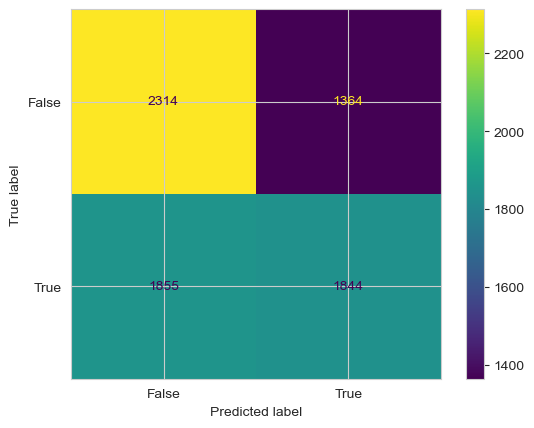

In [104]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(evaluation1, display_labels = [False, True])

cm_display.plot()
plt.show()

In [105]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print("Recall is:",recall_score(Y_test,result2))
print("Precision is:",precision_score(Y_test,result2))
print("Accuracy is:",accuracy_score(Y_test,result2))
print("F1 Score:",f1_score(Y_test,result2))

Recall is: 0.4985131116517978
Precision is: 0.5748129675810474
Accuracy is: 0.5636437576250508
F1 Score: 0.5339510641378312


##Linear SVM

In [106]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear') 
clf.fit(X_train, Y_train)

SVC(kernel='linear')

In [107]:
res = clf.predict(X_test)
res

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

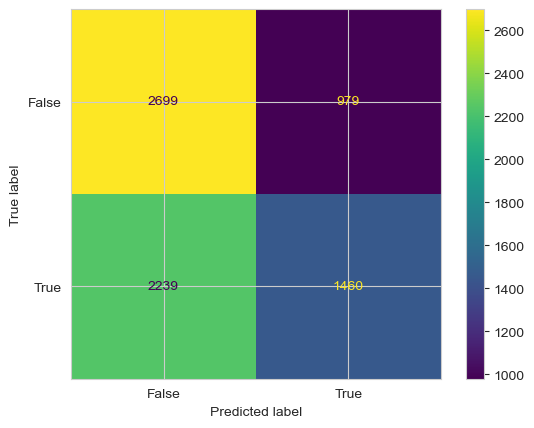

In [108]:
my_matrix = metrics.confusion_matrix(Y_test, res)
cm_display = metrics.ConfusionMatrixDisplay(my_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [109]:
print("Recall is:",recall_score(Y_test,res))
print("Precision is:",precision_score(Y_test,res))
print("Accuracy is:",accuracy_score(Y_test,res))
print("F1 Score:",f1_score(Y_test,res))

Recall is: 0.3947012706136794
Precision is: 0.5986059860598606
Accuracy is: 0.5637793140843161
F1 Score: 0.4757249918540241


##Native Bayes

In [110]:
from sklearn.naive_bayes import GaussianNB
classifier2=GaussianNB()
classifier2.fit(X_train,Y_train)

GaussianNB()

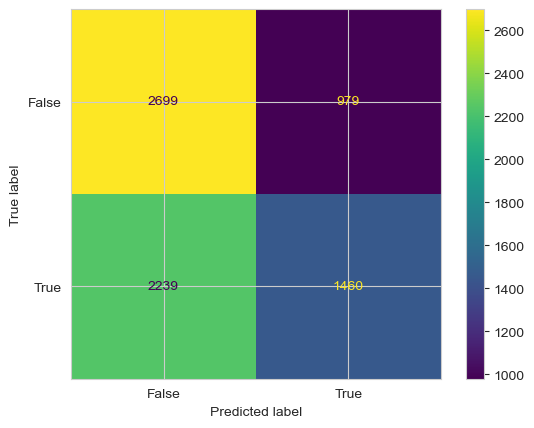

In [111]:
my_matrix = metrics.confusion_matrix(Y_test, res)
cm_display = metrics.ConfusionMatrixDisplay(my_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [112]:
res = classifier2.predict(X_test)
print("Recall is:",recall_score(Y_test,res))
print("Precision is:",precision_score(Y_test,res))
print("Accuracy is:",accuracy_score(Y_test,res))
print("F1 Score:",f1_score(Y_test,res))

Recall is: 0.48202216815355503
Precision is: 0.5872859025032938
Accuracy is: 0.570421580588315
F1 Score: 0.5294729027468449


##K-nearest with K=15

In [113]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
prediction_k = knn.predict(X_test)
print("Recall is:",recall_score(Y_test,prediction_k))
print("Precision is:",precision_score(Y_test,prediction_k))
print("Accuracy is:",accuracy_score(Y_test,prediction_k))
print("F1 Score:",f1_score(Y_test,prediction_k))

Recall is: 0.5185185185185185
Precision is: 0.5997498436522827
Accuracy is: 0.5850616781889657
F1 Score: 0.5561838480498768


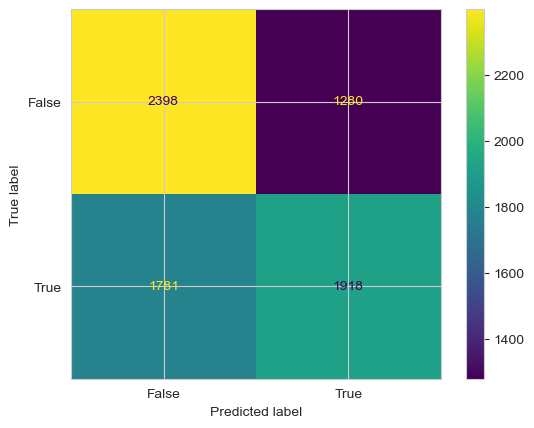

In [114]:
my_matrix = metrics.confusion_matrix(Y_test,prediction_k)
cm_display = metrics.ConfusionMatrixDisplay(my_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#Using Vector Count Model

In [115]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

##Logistic regression

In [116]:
logres = LogisticRegression()
logres.fit(x_train,y_train)

C:\Users\user1\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [117]:
result = logres.predict(x_test)
result

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [118]:
from sklearn.metrics import confusion_matrix
evaluation = confusion_matrix(y_test,result)
evaluation

array([[2681,  997],
       [1036, 2663]], dtype=int64)

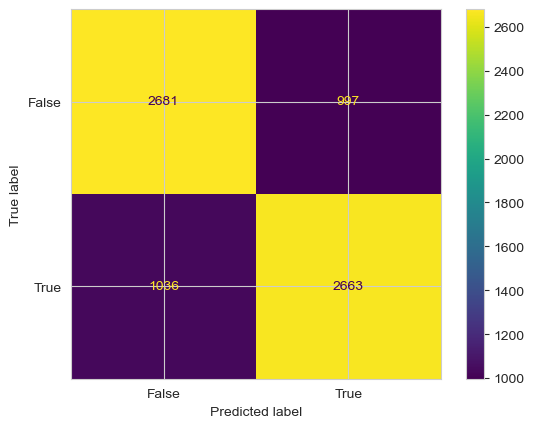

In [119]:
cm_display = metrics.ConfusionMatrixDisplay(evaluation, display_labels = [False, True])

cm_display.plot()
plt.show()

In [120]:
print("Recall is:",recall_score(y_test,result))
print("Precision is:",precision_score(y_test,result))
print("Accuracy is:",accuracy_score(y_test,result))
print("F1 Score:",f1_score(y_test,result))
f1_score_logistic=f1_score(y_test,result)

Recall is: 0.7199243038659097
Precision is: 0.7275956284153006
Accuracy is: 0.7244137183136776
F1 Score: 0.7237396385378448


Getting right and wrong count of best algorthim

In [121]:
right_count = 0
wrong_count = 0
for i in range(0,len(y_test)):
  if(y_test[i] == result[i]): right_count+=1
  else: wrong_count+=1
print(right_count)
print(wrong_count)

5344
2033


##Native Bayes

In [122]:
classifier=GaussianNB()
classifier.fit(x_train,y_train)
Result = classifier.predict(x_test)

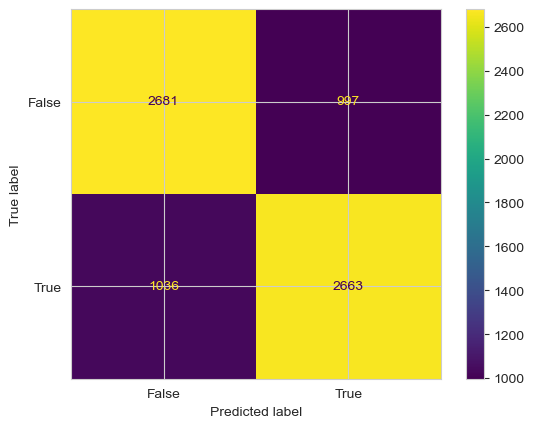

In [123]:
my_matrix = confusion_matrix(y_test,Result)
cm_display = metrics.ConfusionMatrixDisplay(evaluation, display_labels = [False, True])

cm_display.plot()
plt.show()

In [124]:
print("Recall is:",recall_score(y_test,Result))
print("Precision is:",precision_score(y_test,Result))
print("Accuracy is:",accuracy_score(y_test,Result))
print("F1 Score:",f1_score(y_test,Result))

Recall is: 0.11489591781562584
Precision is: 0.4408713692946058
Accuracy is: 0.48312322082147213
F1 Score: 0.18228608192150977


##K-nearest Neighbor with k=15

In [125]:
knn1 = KNeighborsClassifier(n_neighbors=15)
knn1.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=15)

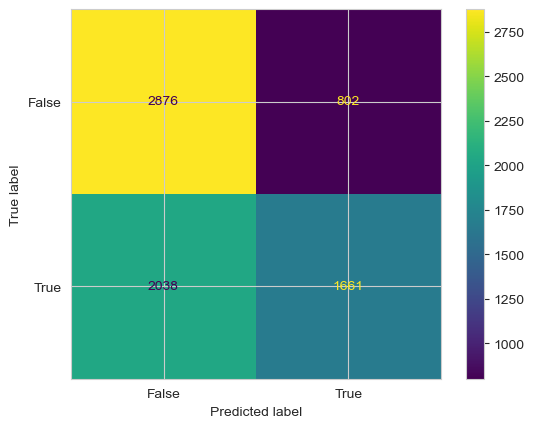

In [126]:
prediction2 = knn1.predict(x_test)

confusion_matrix = metrics.confusion_matrix(y_test, prediction2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [127]:
print("Recall is:",recall_score(y_test,prediction2))
print("Precision is:",precision_score(y_test,prediction2))
print("Accuracy is:",accuracy_score(y_test,prediction2))
print("F1 Score:",f1_score(y_test,prediction2))

Recall is: 0.44904028115706945
Precision is: 0.6743808363784003
Accuracy is: 0.6150196556865934
F1 Score: 0.5391106783511846


In [128]:
# Parameter Turing

In [192]:
#1.2 ->F1 Score: 0.7238846572361262

logres = LogisticRegression(C=1.2)
logres.fit(x_train,y_train)

C:\Users\user1\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.2)

In [193]:
result3 = logres.predict(x_test)
result3

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [194]:
from sklearn.metrics import confusion_matrix
evaluation = confusion_matrix(y_test,result)
evaluation

array([[2681,  997],
       [1036, 2663]], dtype=int64)

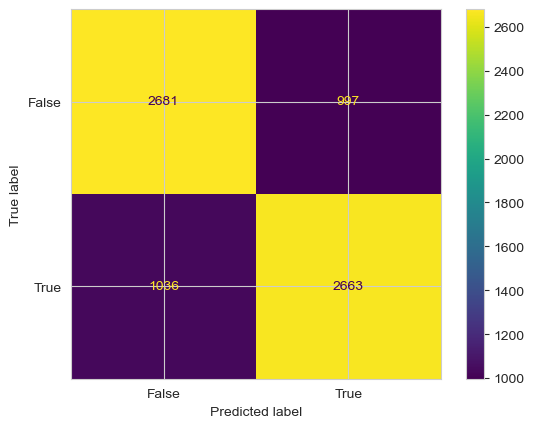

In [195]:
cm_display = metrics.ConfusionMatrixDisplay(evaluation, display_labels = [False, True])

cm_display.plot()
plt.show()

In [196]:
print("Recall is:",recall_score(y_test,result3))
print("Precision is:",precision_score(y_test,result3))
print("Accuracy is:",accuracy_score(y_test,result3))
print("F1 Score:",f1_score(y_test,result3))
f1_score_logistic=f1_score(y_test,result)

Recall is: 0.7193836171938361
Precision is: 0.7284423761292089
Accuracy is: 0.7248203876914735
F1 Score: 0.7238846572361262


In [197]:
right_count = 0
wrong_count = 0
for i in range(0,len(y_test)):
  if(y_test[i] == result[i]): right_count+=1
  else: wrong_count+=1
print(right_count)
print(wrong_count)

5344
2033


#compare btw my analysis and the given one

so the most acurate model is the word count vector using Logistic Regression

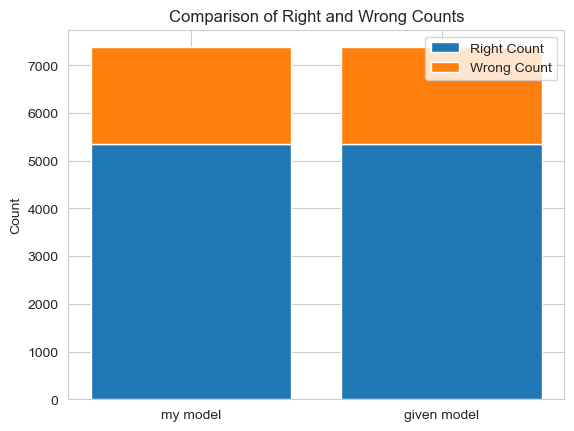

In [135]:
right = [right_count, right_count5]
wrong= [wrong_count, wrong_count5]

labels = ['my model', 'given model']

fig, ax = plt.subplots()
ax.bar(labels, right_count, label='Right Count')
ax.bar(labels, wrong_count, bottom=right_count, label='Wrong Count')

ax.set_ylabel('Count')
ax.set_title('Comparison of Right and Wrong Counts')
ax.legend()
plt.show()

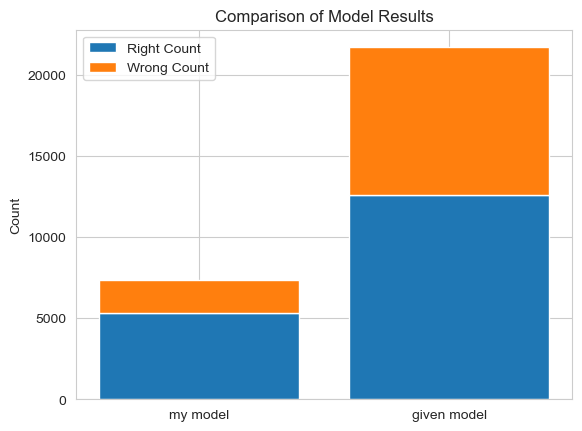

In [136]:
fig, ax = plt.subplots()
ax.bar(labels, [right_count, right_count5], label='Right Count')
ax.bar(labels, [wrong_count, wrong_count5], bottom=[right_count, right_count5], label='Wrong Count')

ax.set_ylabel('Count')
ax.set_title('Comparison of Model Results')
ax.legend()

plt.show()

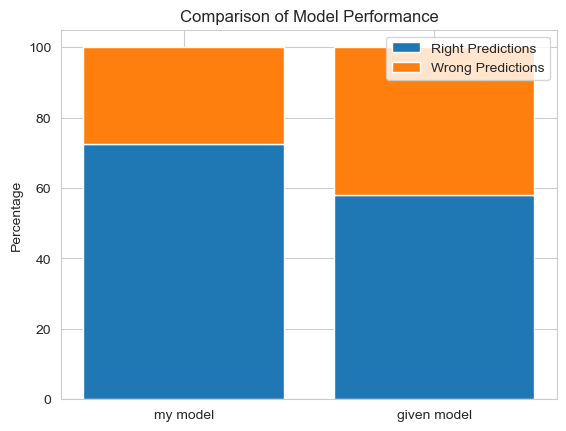

In [137]:
# Calculate the percentages
right_percent3 = right_count / (right_count +wrong_count) * 100
wrong_percent3 = wrong_count / (right_count + wrong_count) * 100
right_percent5 = right_count5 / (right_count5 + wrong_count5) * 100
wrong_percent5 = wrong_count5 / (right_count5 + wrong_count5) * 100

# Create the stacked bar plot
fig, ax = plt.subplots()
ax.bar(labels, [right_percent3, right_percent5], label='Right Predictions')
ax.bar(labels, [wrong_percent3, wrong_percent5], bottom=[right_percent3, right_percent5], label='Wrong Predictions')

# Add labels and legend
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Model Performance')
ax.legend()

# Show the plot
plt.show()

In [138]:
from sklearn.metrics import precision_recall_fscore_support


# Define the actual labels and whether the predictions were right or wrong
y_true = twitter['label']
right_or_wrong = twitter['model_wrong']

# Convert the "right_or_wrong" list into a binary array where 1 represents a correct prediction and 0 represents an incorrect prediction
y_pred = [1 if x == 'False' else 0 for x in right_or_wrong]

# Calculate the precision, recall, and F1 score
precision_given, recall_given, f1_score_given, support_given = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division='warn')

# Print the results
print("Precision: {:.2f}".format(precision_given))
print("Recall: {:.2f}".format(recall_given))
print("F1 Score: {:.2f}".format(f1_score_given))

Precision: 0.57
Recall: 0.48
F1 Score: 0.52


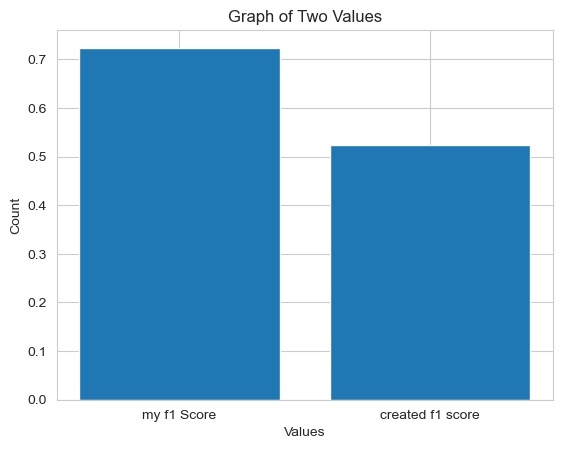

In [139]:
values = [f1_score_logistic, f1_score_given]
# Create the bar plot
plt.bar(["my f1 Score", "created f1 score"], values)

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Count")
plt.title("Graph of Two Values")

# Show the plot
plt.show()

#Making Predictions

In [140]:
twitter3=pd.read_csv('labeled_data.csv',index_col=False)

In [141]:
print(twitter3.columns)

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


In [142]:
twitter3=twitter3[twitter3['class']!=1]

In [143]:
#change nothate(2) to 1
twitter3.loc[twitter3["class"]==2,"class"]=1


print(twitter3)

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      1   
40             40      3            0                   1        2      1   
63             63      3            0                   0        3      1   
66             66      3            0                   1        2      1   
67             67      3            0                   1        2      1   
...           ...    ...          ...                 ...      ...    ...   
24767       25280      3            0                   1        2      1   
24776       25289      3            3                   0        0      0   
24777       25290      3            2                   1        0      0   
24779       25292      3            0                   1        2      1   
24782       25296      3            0                   0        3      1   

                                                   tweet  
0      !!! RT @m

1    4163
0    1430
Name: class, dtype: int64


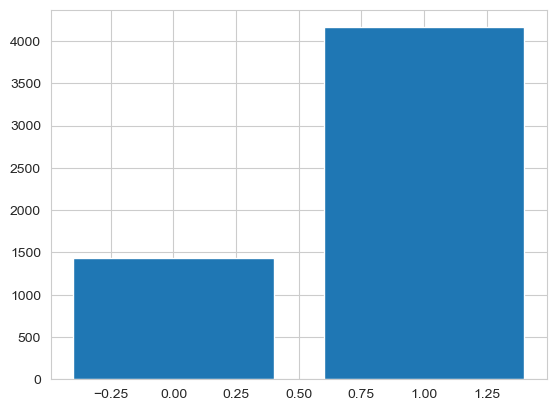

In [144]:
class_counts = twitter3['class'].value_counts()
print(class_counts)

# Plot a bar chart of class distribution
plt.bar(class_counts.index, class_counts.values)
plt.show()

In [145]:
classes=twitter3['class']

In [146]:
twitter3=twitter3.drop(['Unnamed: 0','count', 'hate_speech', 'offensive_language','neither','class'],axis=1)

In [147]:
print(twitter3.columns)

Index(['tweet'], dtype='object')


In [148]:
print(twitter3.isnull().sum())

tweet    0
dtype: int64


In [149]:
print(twitter3.duplicated().sum())

0


In [150]:
twitter3["tweet"] = twitter3["tweet"].apply(lambda i: " ".join(i.lower() for i in i.split()))
print(twitter3['tweet'])

0        !!! rt @mayasolovely: as a woman you shouldn't...
40         " momma said no pussy cats inside my doghouse "
63       "@addicted2guys: -simplyaddictedtoguys http://...
66       "@allaboutmanfeet: http://t.co/3gzupfumev" woo...
67       "@allyhaaaaa: lemmie eat a oreo &amp; do these...
                               ...                        
24767    you know what they say, the early bird gets th...
24776                                   you're all niggers
24777    you're such a retard i hope you get type 2 dia...
24779    you've gone and broke the wrong heart baby, an...
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 5593, dtype: object


In [151]:
import re
pattern = re.compile(r'\b[a-zA-Z]+\b')

In [152]:
def remove_non_english(text):
    return ' '.join(pattern.findall(text))

# apply the function to each text document
twitter3['tweet'] = twitter3['tweet'].apply(remove_non_english)

print(twitter3)

                                                   tweet
0      rt mayasolovely as a woman you shouldn t compl...
40           momma said no pussy cats inside my doghouse
63     simplyaddictedtoguys http t co woof woof hot s...
66     allaboutmanfeet http t co woof woof and hot soles
67     allyhaaaaa lemmie eat a oreo amp do these dish...
...                                                  ...
24767  you know what they say the early bird gets the...
24776                                 you re all niggers
24777  you re such a retard i hope you get type diabe...
24779  you ve gone and broke the wrong heart baby and...
24782  ruffled ntac eileen dahlia beautiful color com...

[5593 rows x 1 columns]


In [153]:
twitter3["tweet"] = twitter3["tweet"].str.replace(r"\d","")
twitter3["tweet"] = twitter3["tweet"].str.replace(r"[^\w\s]","")
twitter3["tweet"] = twitter3["tweet"].str.replace(r"[^[A-Za-z]\s]","")
print(twitter3['tweet'])

0        rt mayasolovely as a woman you shouldn t compl...
40             momma said no pussy cats inside my doghouse
63       simplyaddictedtoguys http t co woof woof hot s...
66       allaboutmanfeet http t co woof woof and hot soles
67       allyhaaaaa lemmie eat a oreo amp do these dish...
                               ...                        
24767    you know what they say the early bird gets the...
24776                                   you re all niggers
24777    you re such a retard i hope you get type diabe...
24779    you ve gone and broke the wrong heart baby and...
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 5593, dtype: object


C:\Users\user1\AppData\Local\Temp\ipykernel_23636\2825249697.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter3["tweet"] = twitter3["tweet"].str.replace(r"\d","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\2825249697.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter3["tweet"] = twitter3["tweet"].str.replace(r"[^\w\s]","")
C:\Users\user1\AppData\Local\Temp\ipykernel_23636\2825249697.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter3["tweet"] = twitter3["tweet"].str.replace(r"[^[A-Za-z]\s]","")


In [154]:
sw = stopwords.words("english")
twitter3["tweet"] = twitter3["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print(twitter3['tweet'])

0        rt mayasolovely woman complain cleaning house ...
40                   momma said pussy cats inside doghouse
63       simplyaddictedtoguys http co woof woof hot sca...
66             allaboutmanfeet http co woof woof hot soles
67       allyhaaaaa lemmie eat oreo amp dishes one oreo...
                               ...                        
24767    know say early bird gets worm puts gummy worms...
24776                                              niggers
24777    retard hope get type diabetes die sugar rush f...
24779      gone broke wrong heart baby drove redneck crazy
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 5593, dtype: object


In [155]:
from textblob import Word
twitter3["tweet"] = twitter3["tweet"].apply(lambda x: " ".join([Word(x).lemmatize()]))
print(twitter3['tweet'])

0        rt mayasolovely woman complain cleaning house ...
40                   momma said pussy cats inside doghouse
63       simplyaddictedtoguys http co woof woof hot sca...
66             allaboutmanfeet http co woof woof hot soles
67       allyhaaaaa lemmie eat oreo amp dishes one oreo...
                               ...                        
24767    know say early bird gets worm puts gummy worms...
24776                                               nigger
24777    retard hope get type diabetes die sugar rush f...
24779      gone broke wrong heart baby drove redneck crazy
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 5593, dtype: object


In [156]:
# Check the number of features in the training dataset
n_features = x_train.shape[1]
print("Number of features in the training dataset:", n_features)


Number of features in the training dataset: 20350


In [157]:
twitter3['text']=twitter3["tweet"]
twitter3=twitter3.drop(['tweet'],axis=1)

In [158]:
new_X = count_vectorizer.transform(twitter3['text']).toarray()
new_y_pred = logres.predict(new_X)
print("Predicted labels:", new_y_pred)

Predicted labels: [0 1 1 ... 0 1 0]


In [159]:
print(new_y_pred)
print(classes)

[0 1 1 ... 0 1 0]
0        1
40       1
63       1
66       1
67       1
        ..
24767    1
24776    0
24777    0
24779    1
24782    1
Name: class, Length: 5593, dtype: int64


In [160]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the predicted labels relative to the true labels
accuracy = accuracy_score(classes, new_y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.6670838548185232
